In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *
from src.cone import *
from src.impedance import ImpedanceEstimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.cluster import KMeans
import cv2

In [4]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))
t2_img = nib.load(str(image_path / t2_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine
T2_vol = t2_img.get_fdata(dtype=np.float32)
T2_affine = t2_img.affine

# Preliminary computations

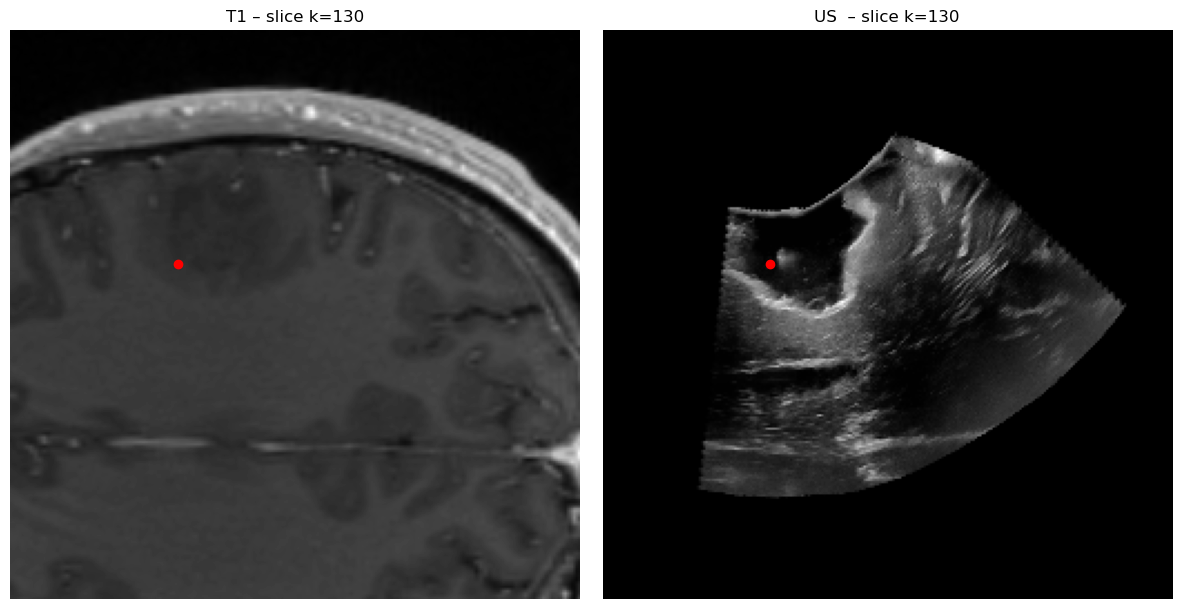

In [5]:
i_mri, j_mri, slice_idx = 150, 75, 130 # Example indices for T1 MRI
us_slice, us_idx = mri_to_us_point(i_mri, j_mri, slice_idx, T1_vol, T1_affine, US_vol, US_affine)
plot_mri_us_aligned(i_mri, j_mri, slice_idx, T1_vol, us_slice, us_idx)

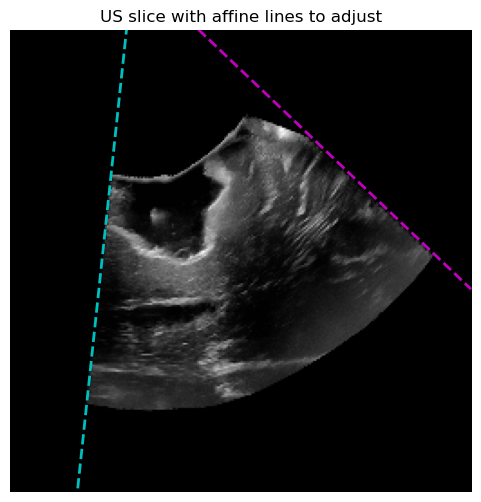

In [6]:
# US edges parameters
mL, bL = 9.4, -350  # Left edge line parameters (slope, intercept)
mR, bR = -0.9524, 355  # Right edge line parameters (slope, intercept)
# mL, bL = -0.1, 216
# mR, bR = 1.05, -117
plot_us_with_affine_lines(us_slice, mL, bL, mR, bR)

_, _, k_us = us_idx
H_us, W_us = us_slice.shape

In [7]:
cone_params = compute_us_apex_and_direction(mL, bL, mR, bR)
x0, y0 = cone_params["apex"]
print("Source :", (x0, y0))
opening_angle   = cone_params["opening_angle"]
direction_vec   = cone_params["direction_vector"]

Source : (68.10015068969514, 290.1414164831343)


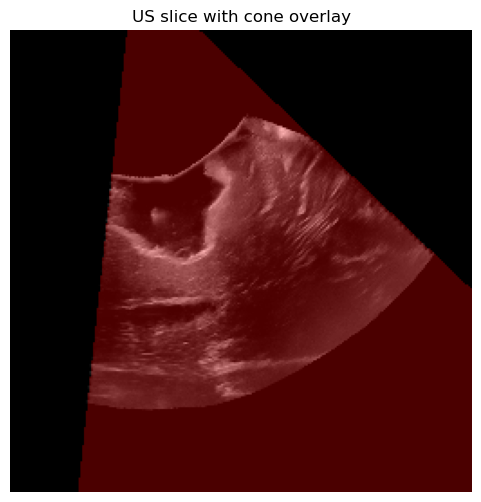

In [8]:
mask_us = overlay_cone(us_slice, apex=np.array([x0, y0]), direction_vector=direction_vec, opening_angle=opening_angle)
plot_overlay_cone(us_slice, mask_us)

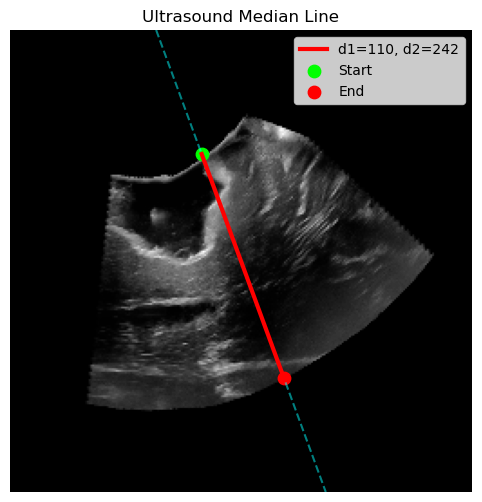

In [33]:
plot_median_line(us_slice, cone_params["apex"], cone_params["direction_vector"], d1=110, d2=242)

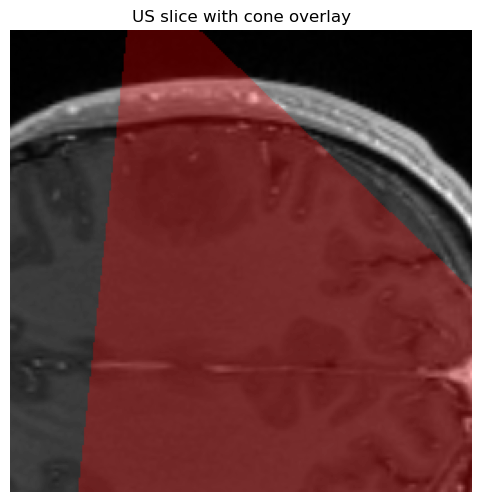

In [9]:
t1_slice = T1_vol[:, :, slice_idx]
H_t1, W_t1 = t1_slice.shape
apex_us_vox = np.array([x0, y0, k_us])

apex_mri_world, direction_mri_world = cone_us_to_mri_world(apex_us_vox, direction_vec, US_affine, T1_affine)

# Visualize result
mask_mri = overlay_cone(t1_slice, apex=apex_mri_world[:2], direction_vector=direction_mri_world, opening_angle=opening_angle)
plot_overlay_cone(t1_slice, mask_mri)

# Train MLP to find Z_vol (Acoustic Impedance)

In [11]:
class ImpedanceLearner(nn.Module):
    """Learning the mapping MRI -> Acoustic Impedance"""
    def __init__(self, input_dim=1, hidden_dims=[32, 32]):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1)
        )
    
    def forward(self, x):
        return self.mlp(x)

class UltrasoundSynthesisModel:
    def __init__(self, renderer, impedance_model, us_real, mask, source, directions, angle):
        """
        renderer: UltrasoundRenderer
        impedance_model: ImpedanceLearner
        us_real: Real ultrasound tensor (n_rays, depth)
        mask: (n_rays, depth)
        source: (3,)
        directions: (n_rays, 3)
        angle: float, angle of the ultrasound beam in radians
        """
        self.renderer = renderer
        self.model = impedance_model
        self.us_real = us_real
        self.mask = mask
        self.source = source
        self.directions = directions
        self.angle = angle
        
        self.real_min = us_real.min()
        self.real_max = us_real.max()
        self.us_real_norm = (us_real - self.real_min) / (self.real_max - self.real_min + 1e-8)
        
    def compute_impedance_volume(self, t1_volume):
        """Converts T1-weighted MRI volume to acoustic impedance volume"""
        masked_volume = t1_volume
        mean = masked_volume.mean()
        std = masked_volume.std()
        vol_norm = (t1_volume - mean) / (std + 1e-8)
        
        with torch.no_grad():
            Z_pred = self.model(vol_norm.unsqueeze(1)).squeeze()
        
        Z_vol = torch.full_like(t1_volume, 400.0)  # Impédance air par défaut
        Z_vol = Z_pred * 1e6
        return Z_vol

    def generate_synthetic_us(self, Z_vol):
        """Generate synthetic ultrasound from impedance volume"""
        synth_us, _ = self.renderer.plot_beam_frame(
            volume=Z_vol,
            source=self.source,
            directions=self.directions,
            angle=self.angle,
            plot=False,
            artifacts=True,
            start=0.4
        )
        return synth_us

    def gradient_loss(self, a, b, mask):
        """Loss robust to edge artifacts"""
        a_grad = torch.abs(a[:, 1:] - a[:, :-1])
        b_grad = torch.abs(b[:, 1:] - b[:, :-1])
        return F.l1_loss(a_grad[mask[:, 1:]], b_grad[mask[:, 1:]])

    def train_step(self, t1_volume, optimizer):
        optimizer.zero_grad()
        
        # Forward pass
        Z_vol = self.compute_impedance_volume(t1_volume)
        synth_us = self.generate_synthetic_us(Z_vol)
        
        # Normalisation
        synth_norm = (synth_us - synth_us.min()) / (synth_us.max() - synth_us.min() + 1e-8)
        
        # Calcul des pertes
        main_loss = F.mse_loss(synth_norm[self.mask], self.us_real_norm[self.mask])
        edge_loss = self.gradient_loss(synth_norm, self.us_real_norm, self.mask)
        total_loss = main_loss + 0.5 * edge_loss
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        
        return total_loss.item()

In [12]:
# # Initialisation des composants
# renderer = UltrasoundRenderer(num_samples=256, attenuation_coeff=0.0001)
# impedance_model = ImpedanceLearner()

# # Charger les données (à adapter)
# t1_volume = torch.randn(128, 128, 128)  # Volume MRI
# brain_mask = t1_volume > 0.5             # Masque cerveau
# us_real = torch.rand(64, 200)             # Ultrason réel
# cone_mask = torch.ones_like(us_real)      # Masque cône

# # Paramètres géométriques
# source = apex_mri_world
# angles = torch.linspace(-45, 45, 64)
# directions = torch.stack([
#     torch.sin(torch.deg2rad(angles)),
#     torch.zeros(64),
#     torch.cos(torch.deg2rad(angles))
# ], dim=1)

# # Initialisation du système
# trainer = UltrasoundSynthesisModel(
#     renderer,
#     impedance_model,
#     us_real,
#     cone_mask,
#     source,
#     directions,
#     angle=45.0
# )

# # Entraînement
# optimizer = torch.optim.Adam(impedance_model.parameters(), lr=1e-4)

# for epoch in range(1000):
#     loss = trainer.train_step(t1_volume, brain_mask, optimizer)
#     print(f"Epoch {epoch}, Loss: {loss:.6f}")

# # Sauvegarde du modèle
# torch.save(impedance_model.state_dict(), "impedance_model.pth")

In [22]:
T1_volume = torch.tensor(T1_vol, dtype=torch.float32)

T1_data = pd.DataFrame(
    {"organ": ["fat","liver","muscle","BWM","BGM","CSF","AIR"],
     "intensity": [260,500,870,780,920,2500, 0], 
     "impedance": [1.34e6,1.67e6,1.68e6,1.6e6,1.6e6,1.5e6, 0.0004e6]}
)

t1 = T1_data['intensity'].values.reshape(-1,1)
z1 = T1_data['impedance'].values.reshape(-1,1)

t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

[INFO] Starting from sample index: 132 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 132 (64, 221)
Intensity range: 0.0000 to 0.0097


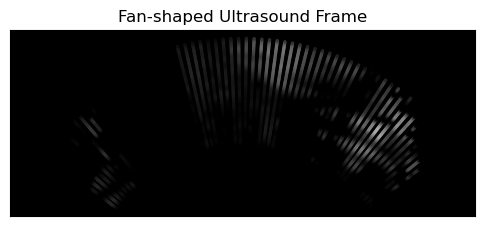

In [32]:
renderer = UltrasoundRenderer(num_samples=220, attenuation_coeff=0.0001)

# Paramètres géométriques
n_rays = 64
source = torch.tensor(apex_mri_world)

def generate_cone_directions(direction_mri_world, opening_angle, n_rays):
    """
    Generate a fan of directions centered on direction_mri_world,
    spanning opening_angle (in radians), in the (x, y) plane (z=0).
    Returns: (n_rays, 3) tensor
    """
    # Normalize the median direction
    d = np.array(direction_mri_world[:2])
    d = d / np.linalg.norm(d)
    # Orthogonal vector in-plane
    ortho = np.array([-d[1], d[0]])
    # Angles from -half to +half opening
    angles = np.linspace(-opening_angle/2, opening_angle/2, n_rays)
    directions = []
    for a in angles:
        v = np.cos(a) * d + np.sin(a) * ortho
        directions.append([v[0], v[1], 0.0])
    return torch.tensor(directions, dtype=torch.float32)

directions = generate_cone_directions(direction_mri_world, opening_angle, n_rays)

synth_us, _ = renderer.plot_beam_frame(
            volume=Z_vol,
            source=source,
            directions=directions,
            angle=np.degrees(opening_angle),
            plot=True,
            artifacts=False,
            start=0.6
        )

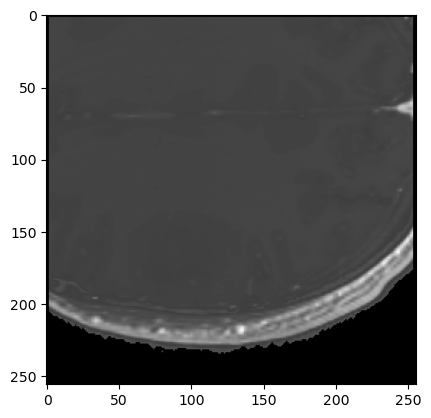

In [27]:
plt.imshow(Z_vol[:, :, slice_idx], cmap='gray')